In [1]:
# Importing the required libraries
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
seed=2 # seed for results reproducability for random map generation
rng = np.random.default_rng(seed)


In [2]:
# import numpy as np
# import matplotlib.pyplot as plt

class MazeGenerator:
    def __init__(self, width, height, density, rng):
        self.width = width
        self.height = height
        self.density = density
        self.seed = seed
        self.grid = self.generate_random_maze()

    def generate_random_maze(self):
        maze = rng.choice([0, 1], size=(self.height, self.width), p=[1-self.density, self.density])
        maze[0, 0] = 0  # Entrance
        maze[-1, -1] = 0  # Exit
        
        
   # Make the entrance and exit
        # Generate a random path from entrance to exit using random walk
        x, y = 0, 0
        while (x, y) != (self.width - 1, self.height - 1):
            directions = [(0, 1), (1, 0)]
            random.shuffle(directions)
            for dx, dy in directions:
                nx, ny = x + dx, y + dy
                if 0 <= nx < self.width and 0 <= ny < self.height:
                    #maze[ny, nx] = 0
                    x, y = nx, ny
                    break        
        
        return maze

    def display(self, start_pos, goal_pos, path=None):
        plt.imshow(self.grid, cmap='binary')

        # Mark the entrance and exit positions
        plt.scatter(start_pos[1], start_pos[0], color='red', marker='o', s=50, label='Start')
        plt.scatter(goal_pos[1], goal_pos[0], color='green', marker='o', s=50, label='Goal')

        if path:
            # Plot the learned path
            path_x, path_y = zip(*path)
            plt.plot(path_y, path_x, marker='o', color='blue', markersize=1, label='Learned Path')

        plt.legend()
        plt.show()







In [3]:
# Create a maze generator instance
# Define the dimensions of the maze
width = 16
height = 16

# Define the density of walls in the maze (between 0 and 1)
density = 0.2
maze_generator = MazeGenerator(width, height, density, rng)

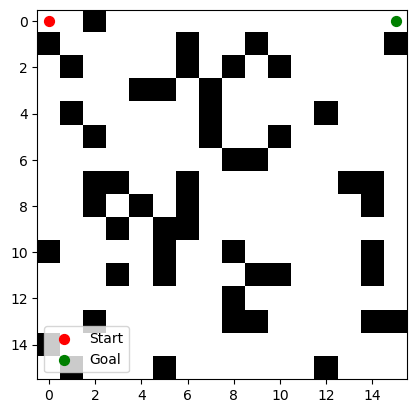

In [4]:


# Specify the starting and goal positions
startPos = (0,0)
goalPos = (0,height-1)

# Display the generated maze as a figure with starting and goal positions
maze_generator.display(startPos, goalPos)

In [5]:
# import numpy as np

class QLearningMazeSolver:
    def __init__(self, rng, maze, startPos, goalPos, alpha=0.1, gamma=1, epsilon=0.1, epochs=15000):
        self.maze = maze
        self.startPos = startPos
        self.goalPos = goalPos
        self.alpha = alpha  # Learning rate
        self.gamma = gamma  # Discount factor
        self.epsilon = epsilon  # Exploration rate
        self.epochs = epochs  # Number of episodes
        self.height, self.width = maze.shape  # Get maze dimensions
        self.q_table = np.zeros((self.height, self.width, 4))  # Q-table: 4 possible actions (up, down, left, right)


    def greedy_policy(self, state): # to find optimal path after TD estimation # also for greedy part of epsilon-greedy action
        q_values = self.q_table[state[0], state[1]]
        max_q_value = np.max(q_values)
        # Find indices of actions with maximum Q-value
        greedy_actions = [i for i, q_value in enumerate(
            q_values) if q_value == max_q_value]
        # If there are multiple greedy actions, randomly select one
        action = rng.choice(greedy_actions)
        #action = np.argmax(q_values)
        return action

    def eps_greedy_policy(self, state):
        if rng.uniform(0, 1) < self.epsilon:
            return rng.choice(np.arange(0, 4, 1))  # Random action (exploration)
        else:
            return self.greedy_policy(state)


    def choose_action(self, state):
        return self.eps_greedy_policy(state)

    def update_q_table_QLearning(self, state, action, reward, next_state): # greedy 
        self.q_table[state[0], state[1], action] += self.alpha * (reward + self.gamma * np.max(self.q_table[next_state[0], next_state[1]]) - self.q_table[state[0], state[1], action])

    def update_q_table_SARSA(self, state, action, reward, next_state, next_action): # behaviour policy # epsilon-greedy 
        self.q_table[state[0], state[1], action] += self.alpha * (reward + self.gamma * self.q_table[next_state[0], next_state[1], next_action] - self.q_table[state[0], state[1], action])

    def update_q_table_nStep_SARSA(self, state, action, G): # behaviour policy # epsilon-greedy 
        self.q_table[state[0], state[1], action] += self.alpha * (G - self.q_table[state[0], state[1], action])

    def solve_maze_QLearning(self):
        episode_steps = []
        for ep in range(self.epochs):
            state = self.startPos
            steps = 0  # Variable to store steps in current episode
            while state != self.goalPos:
                action = self.choose_action(state) # behavior policy # epsilon-greedy
                next_state, reward = self.take_action(state, action) # will use greedy approach for Q value of next state
                self.update_q_table_QLearning(state, action, reward, next_state)
                state = next_state
                steps = steps + 1
            if ep % 100 == 0:
                print(f'episod {ep}, steps {steps}')
                # print('steps = {}'.format(steps))
            episode_steps.append(steps)  # Save total steps for the current episode
                
        return episode_steps
    
    def solve_maze_SARSA(self):
        episode_steps = []
        for ep in range(self.epochs):
            state = self.startPos
            steps = 0  # Variable to store steps in current episode
            while state != self.goalPos:
                action = self.choose_action(state) # behavior policy # epsilon-greedy
                next_state, reward = self.take_action(state, action) 
                next_action = self.choose_action(next_state) # using epsilon-greedy policy
                self.update_q_table_SARSA(state, action, reward, next_state, next_action)
                state = next_state
                action = next_action
                steps = steps + 1
            if ep % 100 == 0:
                print(f'episod {ep}, steps {steps}')
                # print('steps = {}'.format(steps))
            episode_steps.append(steps)  # Save total steps for the current episode
                
        return episode_steps
        
    ## n-step TD: SARSA
    def solve_maze_nStep_SARSA(self, n=10): # n=10
    # def solve_maze_n_step_SARSA(self, n):
        episode_steps = []
        for ep in range(self.epochs):
            state = self.startPos
            steps = 0  # Variable to store steps in current episode
            episode_buffer = []  # Buffer to store state, action, reward tuples
            while state != self.goalPos:
                action = self.choose_action(state) # behavior policy # epsilon-greedy
                next_state, reward = self.take_action(state, action) 
                episode_buffer.append((state, action, reward))  # Store current state, action, reward
                if len(episode_buffer) >= n:  # Start updating after n steps
                    # Calculate n-step return
                    G = sum([episode_buffer[i][2] * (self.gamma ** i) for i in range(n)])
                    # If not at terminal state, add estimated Q value for next state-action pair
                    if next_state != self.goalPos:
                        next_action = self.choose_action(next_state)  # using epsilon-greedy policy
                        G += (self.gamma ** n) * self.q_table[next_state[0], next_state[1], next_action]
                    # Update Q value for the state-action pair n steps ago
                    old_state, old_action, _ = episode_buffer.pop(0)  # Remove oldest state-action-reward tuple # where we started
                    self.update_q_table_nStep_SARSA(old_state, old_action, G)
                state = next_state
                steps += 1
            if ep % 100 == 0:
                print(f'episode {ep}, steps {steps}')
            episode_steps.append(steps)  # Save total steps for the current episode
        return episode_steps


    def take_action(self, state, action):
        actions = [(0, -1), (0, 1), (-1, 0), (1, 0)]  # Possible actions: up, down, left, right
        next_state = (state[0] + actions[action][0], state[1] + actions[action][1])
        
        # Ensure next state is within grid boundaries
        next_state = (max(0, min(self.height - 1, next_state[0])),
                    max(0, min(self.width - 1, next_state[1])))        
        
        # If next position is a wall, keep the next state the same as the current state
        if self.maze[next_state[0], next_state[1]] == 1:
            next_state = state
        
        if next_state == self.goalPos:
            reward = 10  # Reward: 10 for reaching the goal
            done = True  # Episode terminates
        else:
            reward = -1  # Reward: -1 for every movement
            done = False  # Episode continues
        
        return next_state, reward


    def get_path(self):
        path = [self.startPos]
        state = self.startPos
        while state != self.goalPos:
            next_state, _ = self.take_action(state, self.greedy_policy(state))
            path.append(next_state)
            state = next_state
        return path




episod 0, steps 2236
episod 100, steps 22
episod 200, steps 19
episod 300, steps 19
episod 400, steps 17
episod 500, steps 19
episod 600, steps 21
episod 700, steps 17
episod 800, steps 19
episod 900, steps 17
episod 1000, steps 17
episod 1100, steps 20
episod 1200, steps 20
episod 1300, steps 21
episod 1400, steps 18
episod 1500, steps 20
episod 1600, steps 21
episod 1700, steps 17
episod 1800, steps 18
episod 1900, steps 18
episod 2000, steps 22
episod 2100, steps 19
episod 2200, steps 19
episod 2300, steps 21
episod 2400, steps 19
episod 2500, steps 17
episod 2600, steps 24
episod 2700, steps 17
episod 2800, steps 19
episod 2900, steps 21
episod 3000, steps 22
episod 3100, steps 19
episod 3200, steps 17
episod 3300, steps 19
episod 3400, steps 17
episod 3500, steps 17
episod 3600, steps 22
episod 3700, steps 19
episod 3800, steps 18
episod 3900, steps 20
episod 4000, steps 17
episod 4100, steps 23
episod 4200, steps 18
episod 4300, steps 17
episod 4400, steps 18
episod 4500, steps 1

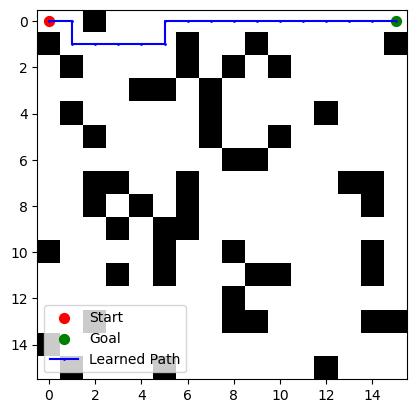

Text(0, 0.5, 'steps')

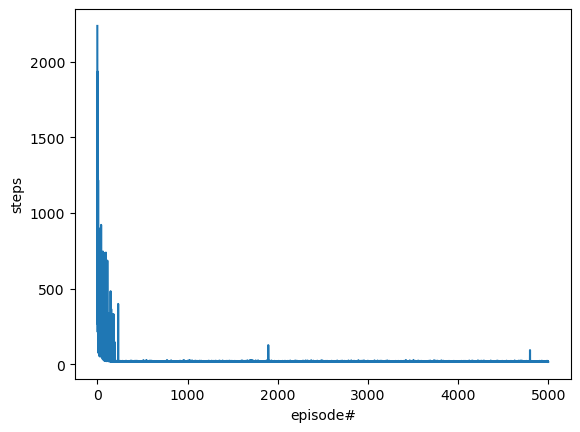

In [6]:
# Example usage: SARSA
solver = QLearningMazeSolver(rng, maze_generator.grid, startPos, goalPos, epochs=5000)
episode_steps_SARSA = solver.solve_maze_SARSA()

path = solver.get_path()
print(path)
# Display the maze with the learned path
maze_generator.display(startPos, goalPos, path)

plt.plot(episode_steps_SARSA)
plt.xlabel('episode#')
plt.ylabel('steps')

episod 0, steps 2014
episod 100, steps 163
episod 200, steps 19
episod 300, steps 23
episod 400, steps 19
episod 500, steps 17
episod 600, steps 17
episod 700, steps 20
episod 800, steps 19
episod 900, steps 17
episod 1000, steps 21
episod 1100, steps 17
episod 1200, steps 19
episod 1300, steps 19
episod 1400, steps 17
episod 1500, steps 18
episod 1600, steps 19
episod 1700, steps 17
episod 1800, steps 18
episod 1900, steps 22
episod 2000, steps 20
episod 2100, steps 21
episod 2200, steps 20
episod 2300, steps 17
episod 2400, steps 21
episod 2500, steps 17
episod 2600, steps 21
episod 2700, steps 17
episod 2800, steps 20
episod 2900, steps 19
episod 3000, steps 18
episod 3100, steps 25
episod 3200, steps 17
episod 3300, steps 21
episod 3400, steps 17
episod 3500, steps 18
episod 3600, steps 21
episod 3700, steps 17
episod 3800, steps 17
episod 3900, steps 17
episod 4000, steps 25
episod 4100, steps 18
episod 4200, steps 17
episod 4300, steps 17
episod 4400, steps 20
episod 4500, steps 

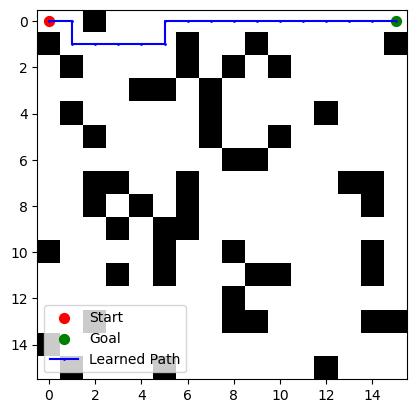

Text(0, 0.5, 'steps')

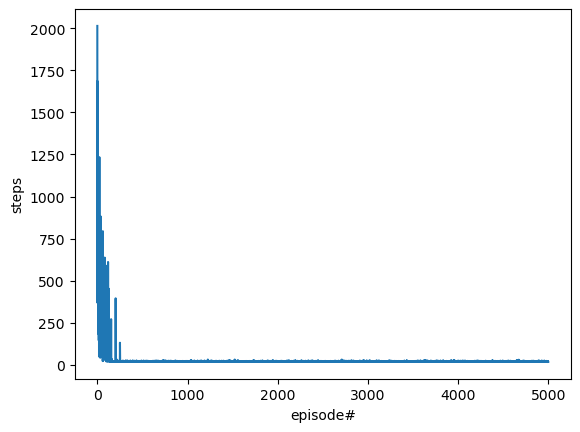

In [7]:
# Example usage: QLearning
solver = QLearningMazeSolver(rng, maze_generator.grid, startPos, goalPos, epochs=5000)
episode_steps_QL = solver.solve_maze_QLearning()

path = solver.get_path()
print(path)
# Display the maze with the learned path
maze_generator.display(startPos, goalPos, path)

plt.plot(episode_steps_QL)
plt.xlabel('episode#')
plt.ylabel('steps')

In [ ]:
# Example usage: nStep SARSA
solver = QLearningMazeSolver(rng, maze_generator.grid, startPos, goalPos, epochs=5000)
episode_steps_nStep_SARSA = solver.solve_maze_nStep_SARSA(n=5) # n=1 for simple SARSA

path = solver.get_path()
print(path)
# Display the maze with the learned path
maze_generator.display(startPos, goalPos, path)

plt.plot(episode_steps_nStep_SARSA)
plt.xlabel('episode#')
plt.ylabel('steps')

episode 0, steps 1890
episode 100, steps 18
episode 200, steps 23
episode 300, steps 18
episode 400, steps 23
episode 500, steps 20
episode 600, steps 21
episode 700, steps 18
episode 800, steps 19
episode 900, steps 17
episode 1000, steps 19
episode 1100, steps 19
episode 1200, steps 25
episode 1300, steps 26
episode 1400, steps 18
episode 1500, steps 17
episode 1600, steps 19
episode 1700, steps 18


In [ ]:
## Randomness in policies learnt due to randomness in greedy policy (multiple greedy actions) and epsilon-greedy policy (exploration)
# removed randomness by seed